<a href="https://colab.research.google.com/github/alexistaylor3/CS536_FinalProject/blob/main/cifar_new_resnet_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def resnet18_cifar10(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


# Example model
model = resnet18_cifar10()


NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.3 GB
Cached:    3.8 GB


C:\Users\Lexi\AppData\Local\Temp\ipykernel_16568\129089218.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified
[1,  1000] loss: 2.725, Ça coûte 18.325
[2,  1000] loss: 3.180, Ça coûte 18.969
[3,  1000] loss: 1.972, Ça coûte 19.522
[4,  1000] loss: 1.319, Ça coûte 19.990
[5,  1000] loss: 0.981, Ça coûte 19.540
[6,  1000] loss: 0.737, Ça coûte 18.784
[7,  1000] loss: 0.526, Ça coûte 18.130
[8,  1000] loss: 0.341, Ça coûte 17.550
[9,  1000] loss: 0.216, Ça coûte 18.128
[10,  1000] loss: 0.134, Ça coûte 18.828
[11,  1000] loss: 0.101, Ça coûte 18.602
[12,  1000] loss: 0.077, Ça coûte 18.369
[13,  1000] loss: 0.067, Ça coûte 18.940
[14,  1000] loss: 0.060, Ça coûte 18.795
[15,  1000] loss: 0.050, Ça coûte 19.969
[16,  1000] loss: 0.045, Ça coûte 19.514
[17,  1000] loss: 0.041, Ça coûte 18.948
[18,  1000] loss: 0.038, Ça coûte 17.896
[19,  1000] loss: 0.036, Ça coûte 17.261
[20,  1000] loss: 0.033, Ça coûte 17.606
[21,  1000] loss: 0.030, Ça coûte 18.333
[22,  1000] loss: 0.031, Ça coûte 18.169
[23,  1000] loss: 0.026, Ça coû

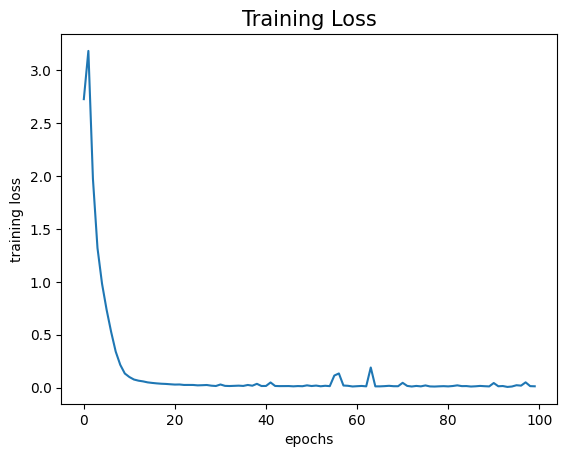

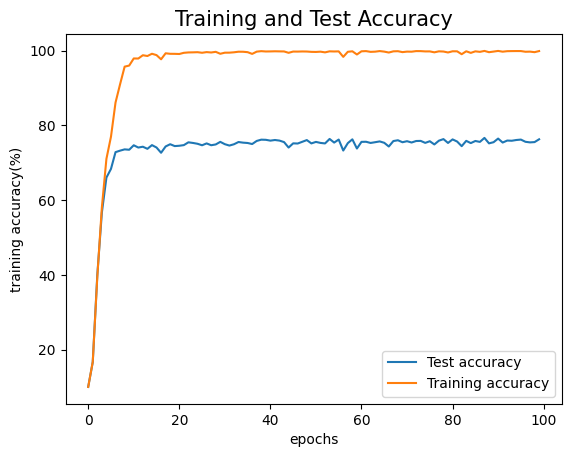

In [7]:
"""
Batch Size: 32
Beta 2: 0.99
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(len(train_acc_vec))
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=32
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=1 , pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=1 , pin_memory=True)

beta_1 = 0.0
beta_2 = 0.99

# resnet
net = resnet18_cifar10(num_classes=10)
net.eval()

net = net.to(device, non_blocking=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.4 GB


C:\Users\Lexi\AppData\Local\Temp\ipykernel_16568\898737918.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified
[1,    50] loss: 5.376, Ça coûte 12.390
[2,    50] loss: 2.302, Ça coûte 12.875
[3,    50] loss: 2.328, Ça coûte 12.649
[4,    50] loss: 2.081, Ça coûte 12.808
[5,    50] loss: 1.865, Ça coûte 13.085
[6,    50] loss: 1.654, Ça coûte 13.348
[7,    50] loss: 1.487, Ça coûte 13.515
[8,    50] loss: 1.361, Ça coûte 13.207
[9,    50] loss: 1.231, Ça coûte 13.336
[10,    50] loss: 1.118, Ça coûte 14.414
[11,    50] loss: 0.985, Ça coûte 13.948
[12,    50] loss: 0.891, Ça coûte 13.196
[13,    50] loss: 0.768, Ça coûte 13.286
[14,    50] loss: 0.641, Ça coûte 13.819
[15,    50] loss: 0.536, Ça coûte 13.667
[16,    50] loss: 0.425, Ça coûte 14.062
[17,    50] loss: 0.350, Ça coûte 14.910
[18,    50] loss: 0.301, Ça coûte 14.031
[19,    50] loss: 0.168, Ça coûte 13.743
[20,    50] loss: 0.116, Ça coûte 13.387
[21,    50] loss: 0.144, Ça coûte 14.252
[22,    50] loss: 0.018, Ça coûte 13.913
[23,    50] loss: 0.043, Ça coû

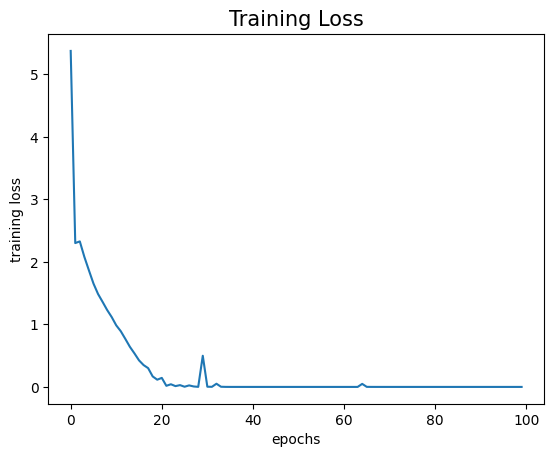

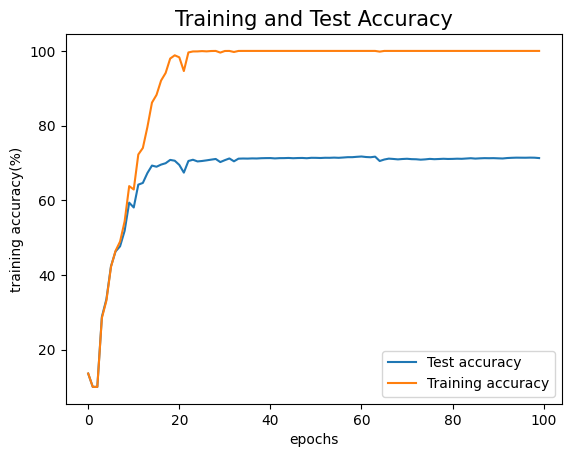

In [4]:
"""
Batch Size: 512
Beta 2: 0.99
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=50
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(len(train_acc_vec))
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=512
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=1 , pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=1 , pin_memory=True)

beta_1 = 0.0
beta_2 = 0.99

# resnet
net = resnet18_cifar10(num_classes=10)
net.eval()

net = net.to(device, non_blocking=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "NewLR-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
